<a href="https://colab.research.google.com/github/KannishreeK/Myntra-HackerRamp/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fashion-product-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F139630%2F329006%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T173013Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D76cee701db08e201bb44f4c0461e14eccb43309c287d925e3e8aaa0ec21475a123f170bceab1bfac820fa38bc4b84d03406bf188ebb71acf0a24b86ae3e88cb6ef7e8aa81539c7402159c66b5f1d67d9aa4830388514bf1d448c5f5a1fbbdd7a02816f38bd1342c0a664b29f031f790b06d3114f107bc1f3da0a1bd8f5e38d3e5adf8cdef88c080a6f7880e29217612379f39938c3c582385acba1abd209c5ce5ecb99fc501c7ea2bb2a8d3e921119c39a0efffbc820754ac1bf2ed5ca1d9e2d3a61fd28a072f52784519a9926d52564843d4f4de555c962925639917891e9c3d129a4e9aea48c71c156139e5b3887d2a7aca65ecf525e9c85d26cbb91dde431'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 24771215740 bytes downloaded
Downloaded and uncompressed: fashion-product-images-dataset
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

# Data Preparation

In [ ]:
path = '../input/fashion-product-images-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) # list content of dataset
dirs_names

['styles.csv', 'fashion-dataset', 'images', 'images.csv', 'styles']

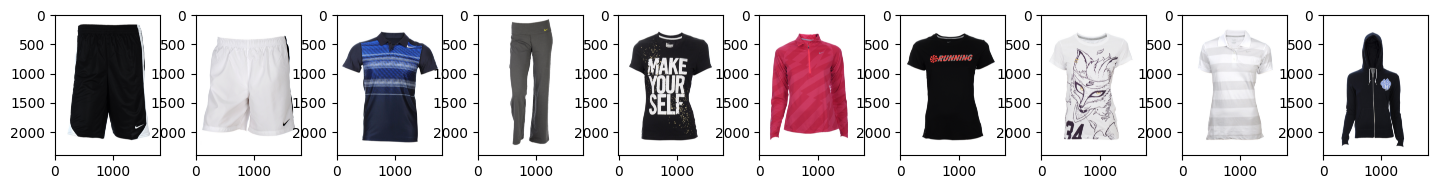

In [ ]:
# Plot samples
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100' + str(i) +'.jpg') # Assign images ids
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [ ]:
styles_df = pd.read_csv(path + "styles.csv", nrows=6000, on_bad_lines='skip') # Read 6000 product and drop bad lines
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
print(styles_df.shape)
styles_df.head(5)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


<Axes: ylabel='articleType'>

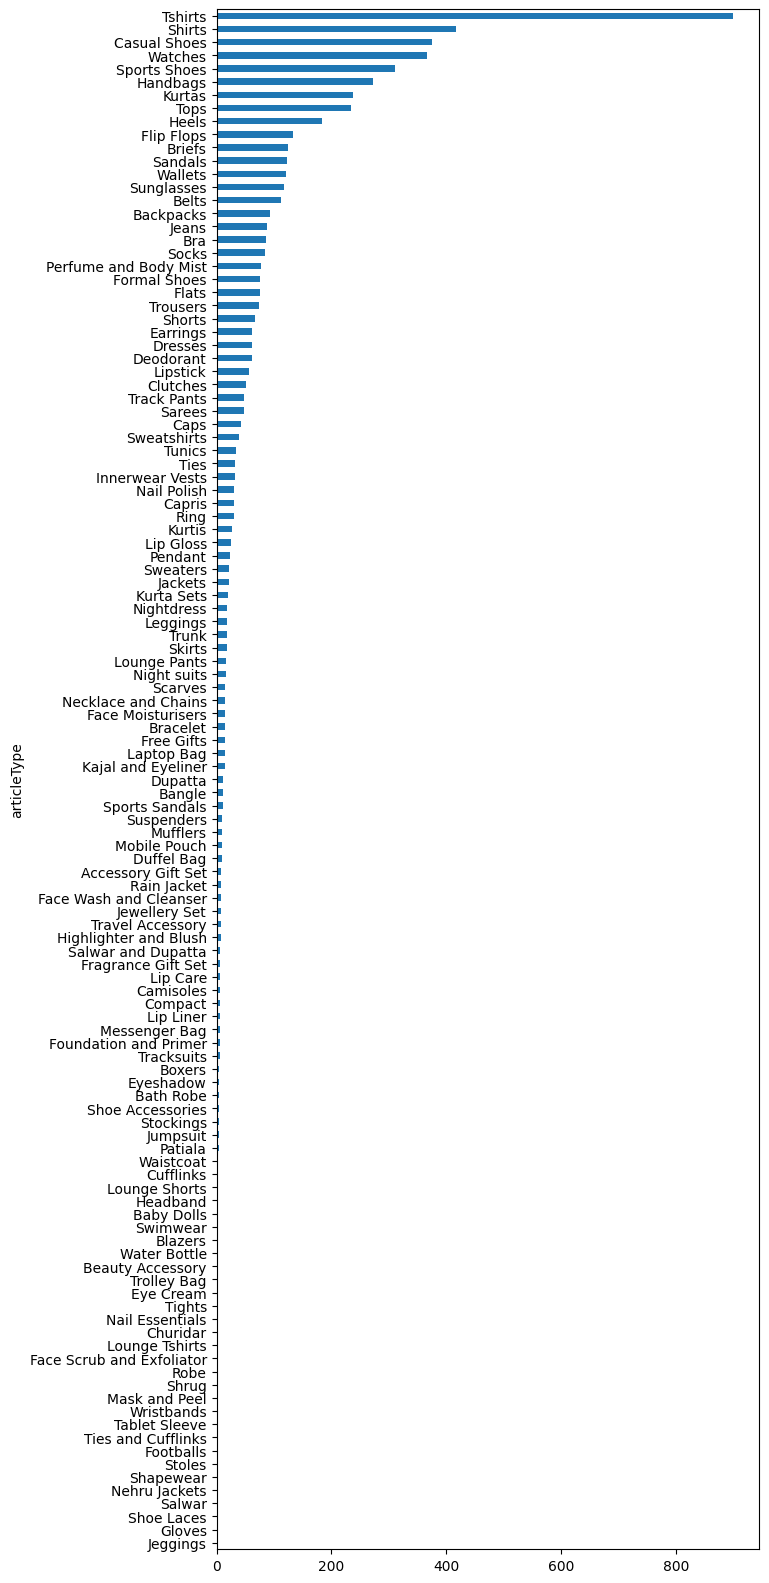

In [ ]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

# Modeling and Get Image Embeddings

In [ ]:
img_width, img_height, chnls = 100, 100, 3

In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable=False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
def img_path(img):
    """ Take image name(id) and return the complete path of it """
    return path + 'images/' + img

def predict(model, img_name):
    """ Load and preprocess image then make prediction """
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [ ]:
def get_embeddings(df, model):
    """ Return a dataframe contains images features """
    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(styles_df, vgg16_model)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 116ms/step


In [ ]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.000000,0.0,0.000000,0.0,0.143262,0.00000,0.000000,0.0,0.0,0.0,...,0.265156,3.163679,0.000000,0.000000,3.598499,0.094586,0.000000,0.000000,0.400017,3.075927
1,0.214865,0.0,0.642268,0.0,0.721051,0.00000,0.961315,0.0,0.0,0.0,...,0.972880,3.489842,0.444948,1.035509,4.321328,0.276158,0.657144,1.072055,0.752607,2.018364
2,1.869813,0.0,0.000000,0.0,0.445198,0.00000,0.000000,0.0,0.0,0.0,...,0.895740,0.185554,0.671141,0.076805,0.000000,0.400541,0.000000,0.000000,0.968235,0.000000
3,0.067576,0.0,0.000000,0.0,0.598626,0.00000,0.206587,0.0,0.0,0.0,...,1.043817,2.009501,0.382332,0.000000,1.067551,0.187985,0.000000,0.000000,0.145138,3.934349
4,0.000000,0.0,0.000000,0.0,0.090579,0.16434,0.000000,0.0,0.0,0.0,...,0.535294,0.341518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115650,1.671089


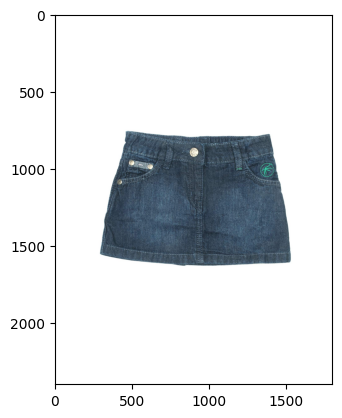

In [ ]:
url="../input/fashion-product-images-dataset/fashion-dataset/images/10002.jpg"
a = plt.imread(url)
plt.imshow(a)

In [ ]:
sample_image = predict(vgg16_model, '10002.jpg')
sample_image.shape

1/1 [==============================] - 0s 250ms/step


(1, 512)

In [ ]:
df_sample_image = pd.DataFrame(sample_image)
print(df_sample_image)

        0    1    2    3    4    5         6    7    8        9    ...  \
0  0.062589  0.0  0.0  0.0  0.0  0.0  2.559994  0.0  0.0  0.32258  ...   

        502       503      504       505       506       507       508  509  \
0  2.128376  0.208679  0.08558  0.056417  1.235372  1.128909  0.561491  0.0   

        510  511  
0  0.658177  0.0  

[1 rows x 512 columns]


In [ ]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

[[268.788   329.45557 274.25513 ... 343.82996 307.4849  328.6706 ]]


In [ ]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(vgg16_model, '10002.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [ ]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [ ]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(2790, 1.0), (4897, 0.9889593), (1588, 0.98219997), (5253, 0.98219997), (5216, 0.8989176)]
../input/fashion-product-images-dataset/fashion-dataset/images/28005.jpg
../input/fashion-product-images-dataset/fashion-dataset/images/10001.jpg
../input/fashion-product-images-dataset/fashion-dataset/images/41007.jpg
../input/fashion-product-images-dataset/fashion-dataset/images/41006.jpg
../input/fashion-product-images-dataset/fashion-dataset/images/5005.jpg


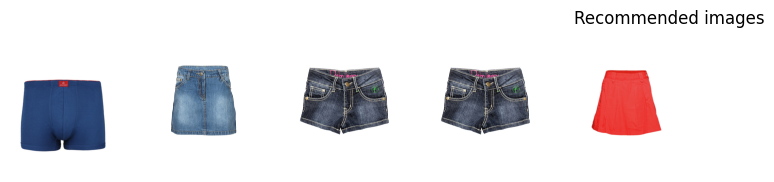

In [ ]:
recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    print(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

# Reusable class for production

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """

    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
    # Helper functions
    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=6000, on_bad_lines='skip') # Read 6000 product and drop bad lines
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df

    def load_model(self):
        """ Load our model """
        vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        vgg16.trainable=False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100))
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)

    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity

    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm

    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]

    def print_recommendations(self):
        """ Print the top 5 most similar products"""
        recommendation = self.get_recommendations()
        recommendation_list = recommendation.to_list()
        #recommended images
        plt.figure(figsize=(20,20))
        j=0
        for i in recommendation_list:
            plt.subplot(6, 10, j+1)
            cloth_img =  mpimg.imread("../input/fashion-product-images-dataset/fashion-dataset/" + 'images/'+ i)
            plt.imshow(cloth_img)
            plt.axis("off")
            j+=1
        plt.title("Recommended images",loc='left')
        plt.subplots_adjust(wspace=-0.5, hspace=1)
        plt.show()
        return

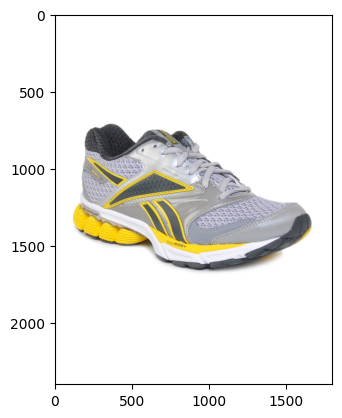

In [ ]:
url = "../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

1/1 [==============================] - 0s 312ms/step
[(855, 1.0), (2688, 0.94127107), (3886, 0.9183083), (709, 0.88677865), (5364, 0.8847835)]


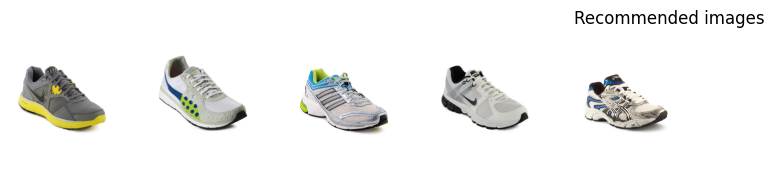

In [ ]:
img_path = '../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg'
styles_path = '../input/fashion-product-images-dataset/fashion-dataset/styles.csv'
obj = fashion_recommendations(img_path, df_embeddings, styles_path)
obj.print_recommendations()

In [ ]:

df=styles_df.copy()
# Example feature engineering (assuming season and usage are in the dataset)
# Convert 'season' and 'usage' to categorical features
df['season'] = df['season'].astype('category')
df['usage'] = df['usage'].astype('category')

# Display the unique values for verification
print(df['season'].unique())
print(df['usage'].unique())
print(df.columns)



['Fall', 'Summer', 'Winter', 'Spring', NaN]
Categories (4, object): ['Fall', 'Spring', 'Summer', 'Winter']
['Casual', 'Ethnic', 'Formal', 'Sports', NaN, 'Smart Casual', 'Travel', 'Party']
Categories (7, object): ['Casual', 'Ethnic', 'Formal', 'Party', 'Smart Casual', 'Sports', 'Travel']
Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
      dtype='object')


In [ ]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder

# Load the dataset

# Columns to be used as features
feature_columns = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage']

# One-Hot Encoding for categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[feature_columns])

# Function to recommend products based on season and usage
def recommend_products_based_on_season_and_usage(user_preferences, season, usage, num_recommendations=5):
    # Filter the dataset based on season and usage
    filtered_df = df[(df['season'] == season) & (df['usage'] == usage)]

    # Check if the filtered dataframe is empty
    if filtered_df.empty:
        print(f"No products found for season '{season}' and usage '{usage}'")
        return pd.DataFrame()

    # Encode the filtered dataframe features
    filtered_encoded_features = encoder.transform(filtered_df[feature_columns])

    # Get the features of the user's preferred product
    user_product = df[df['id'] == user_preferences]

    # Check if user product exists in the dataset
    if user_product.empty:
        print(f"No product found for user preference ID '{user_preferences}'")
        return pd.DataFrame()

    user_product_encoded_features = encoder.transform(user_product[feature_columns])

    # Find the nearest neighbors
    model = NearestNeighbors(n_neighbors=num_recommendations, algorithm='ball_tree')
    model.fit(filtered_encoded_features)

    distances, indices = model.kneighbors(user_product_encoded_features)

    # Get recommended products
    recommended_products = filtered_df.iloc[indices[0]]

    return recommended_products

# Example usage
user_preferences = 15970
season = 'Winter'
usage = 'Casual'

recommended_products = recommend_products_based_on_season_and_usage(user_preferences, season, usage)

# Check if there are recommended products
if not recommended_products.empty:
    print(recommended_products[['id', 'productDisplayName', 'season', 'usage']])
else:
    print("No recommendations found.")


         id                          productDisplayName  season   usage
1569  14037        Flying Machine Men Check Blue Shirts  Winter  Casual
476   19786  U.S. Polo Assn. Men Solid Navy Blue Tshirt  Winter  Casual
2294  14039       Flying Machine Men Check Green Shirts  Winter  Casual
754    1890            FIFA Mens Essentials Red T-shirt  Winter  Casual
1221  19788      U.S. Polo Assn. Men Solid Green Tshirt  Winter  Casual


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


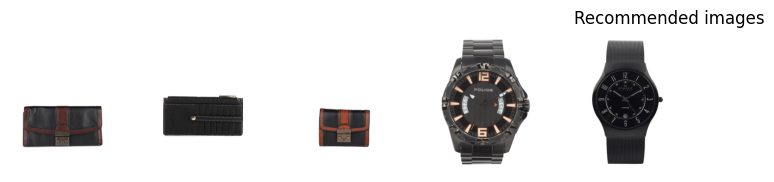

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
# Assuming 'df' is already loaded with the fashion products dataset

# Columns to be used as features
feature_columns = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage']

# One-Hot Encoding for categorical features
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[feature_columns])

# Function to recommend products based on season and usage
def recommend_products_based_on_season_and_usage(user_preferences, season, usage, num_recommendations=5):
    # Filter the dataset based on season and usage
    filtered_df = df[(df['season'] == season) & (df['usage'] == usage)]

    # Check if the filtered dataframe is empty
    if filtered_df.empty:
        print(f"No products found for season '{season}' and usage '{usage}'")
        return pd.DataFrame()

    # Encode the filtered dataframe features
    filtered_encoded_features = encoder.transform(filtered_df[feature_columns])

    # Get the features of the user's preferred product
    user_product = df[df['id'] == user_preferences]

    # Check if user product exists in the dataset
    if user_product.empty:
        print(f"No product found for user preference ID '{user_preferences}'")
        return pd.DataFrame()

    user_product_encoded_features = encoder.transform(user_product[feature_columns])

    # Find the nearest neighbors
    model = NearestNeighbors(n_neighbors=num_recommendations, algorithm='ball_tree')
    model.fit(filtered_encoded_features)

    distances, indices = model.kneighbors(user_product_encoded_features)

    # Get recommended products
    recommended_products = filtered_df.iloc[indices[0]]

    return recommended_products

# Example usage
user_preferences = 14869
season = 'Winter'
usage = 'Casual'

recommended_products = recommend_products_based_on_season_and_usage(user_preferences, season, usage)

path = '../input/fashion-product-images-dataset/fashion-dataset/'
# Function to get recommendations and display images
def get_recommendations_and_display(df, recommendations):
    if recommendations.empty:
        print("No recommendations found.")
        return
    #df['image'].iloc[cloth_indices]
    # Extract image paths
    recommendations['image'] =  recommendations['image']
    recommendation_list = recommendations['image'].tolist()

    # Display recommended images
    plt.figure(figsize=(20, 20))
    j = 0
    for img_path in recommendation_list:
        plt.subplot(6, 10, j + 1)
        if os.path.exists(path + 'images/'+ img_path):
            cloth_img = mpimg.imread(path + 'images/'+ img_path)
            plt.imshow(cloth_img)
            plt.axis("off")
        else:
            print(f"Image not found: {img_path}")
        j += 1
    plt.title("Recommended images", loc='left')
    plt.subplots_adjust(wspace=-0.5, hspace=1)
    plt.show()

# Display the recommended products
get_recommendations_and_display(df, recommended_products)
